# Login / Switch DEV_TEST_PROD environment (1-timer)

In [1]:
import azureml.core
print(azureml.core.VERSION)

1.44.0


In [2]:
import sys
sys.path.insert(0, "../azure-enterprise-scale-ml/esml/common/")
from azureml.core.authentication import InteractiveLoginAuthentication
from esml import ESMLProject

p = ESMLProject()
p.dev_test_prod="dev"
auth = InteractiveLoginAuthentication(tenant_id = p.tenant)
ws, config_name = p.authenticate_workspace_and_write_config(auth)

Using lake_settings.json with ESML version 1.4 - Models array support including LABEL


# 1) ESML - TRAIN, Calculate test_Set scoring, register, compare, and DEPLOY with predict_proba scoring

In [1]:
import sys
sys.path.insert(0, "../azure-enterprise-scale-ml/esml/common/")
from esml import ESMLProject
import pandas as pd

p = ESMLProject() # Will search in ROOT for your copied SETTINGS folder '../../../settings', you should copy template settings from '../settings'
p.active_model = 11
p.inference_mode = False
p.ws = p.get_workspace_from_config() #2) Load DEV or TEST or PROD Azure ML Studio workspace
p.verbose_logging = False
p.describe()

Using lake_settings.json with ESML version 1.4 - Models array support including LABEL
Environment: dev
Inference version: 1

 - ds01_diabetes
projects/project002/11_diabetes_model_reg/train/ds01_diabetes/in/dev/1000/01/01/
projects/project002/11_diabetes_model_reg/train/ds01_diabetes/out/bronze/dev/
projects/project002/11_diabetes_model_reg/train/ds01_diabetes/out/silver/dev/

 - ds02_other
projects/project002/11_diabetes_model_reg/train/ds02_other/in/dev/1000/01/01/
projects/project002/11_diabetes_model_reg/train/ds02_other/out/bronze/dev/
projects/project002/11_diabetes_model_reg/train/ds02_other/out/silver/dev/
 

Training GOLD (p.GoldPath)
projects/project002/11_diabetes_model_reg/train/gold/dev/
 

[A) USAGE]: to_score_folder, scored_folder, date_folder = p.get_gold_scored_unique_path()
A)INFERENCE ONLINE: GOLD to score (example if realtime - today)
projects/project002/11_diabetes_model_reg/inference/1/gold/dev/2022_09_11/a89e4c34527b464b88ce41af63e72ced/
 

A)INFERENCE ONLINE: GO

In [3]:
def test_feature_engieering():
    # Feture engineering: Bronze 2 Gold - working with Azure ML Datasets with Bronze, Silver, Gold concept
    esml_dataset = p.DatasetByName("ds01_diabetes") # Get dataset
    df_bronze = esml_dataset.Bronze.to_pandas_dataframe()
    p.save_silver(esml_dataset,df_bronze) #Bronze -> Silver

    esml_dataset2 = p.DatasetByName("ds02_other") # Get dataset
    df_bronze2 = esml_dataset2.Bronze.to_pandas_dataframe()
    p.save_silver(esml_dataset2,df_bronze2) #Bronze -> Silver

    df = esml_dataset.Silver.to_pandas_dataframe() 
    df_filtered = df[df.AGE > 0.015] 
    gold = p.save_gold(df_filtered)  #Silver -> Gold
    return gold

In [19]:
datastore = None
gold = None
M10_GOLD_TRAIN, M10_GOLD_VALIDATE, M10_GOLD_TEST = None,None,None

try:
    datastore = p.connect_to_lake() # Connects to the correct ALDS GEN 2 storage account (DEV, TEST or PROD)
    gold_train = p.GoldTrain
    gold_train.name
    print("Not 1st time. We have data mapped already...and splitted. Now connected to LAKE")
except: # If 1st time....no Gold exists, nor any mapping
    print("1st time. Lets init, map what data we have in LAKE, as Azure ML Datasets")
    datastore = p.init() # 3) Automapping from datalake to Azure ML datasets
    gold = test_feature_engieering()
    M10_GOLD_TRAIN, M10_GOLD_VALIDATE, M10_GOLD_TEST = p.split_gold_3(0.6,stratified=False) # Splits and Auto-registers as AZUREM ML Datasets

Using GEN2 as Datastore
Searching for setting in ESML datalake...
ESML in-folder settings override = TRUE 
 - Found settings in the ESML AutoLake  [active_in_folder.json,active_scoring_in_folder.json], to override ArgParse/GIT config with.
 - TRAIN in date:  1000/01/01
 - INFERENCE in date: 2021/06/08 and ModelVersion to score with: 1 (0=latest)
Not 1st time. We have data mapped already...and splitted. Now connected to LAKE


datastore = None
try:
    datastore = p.connect_to_lake() # Connects to the correct ALDS GEN 2 storage account (DEV, TEST or PROD)
    gold_train = p.GoldTrain
    gold_train.name
    print("Not 1st time. We have data mapped already...and splitted. Now connected to LAKE")
except: # If 1st time....no Gold exists, nor any mapping
    print("1st time. Lets init, map what data we have in LAKE, as Azure ML Datasets")
    datastore = p.init() # 3) Automapping from datalake to Azure ML datasets
    gold = test_feature_engieering()

In [5]:
p.Gold.to_pandas_dataframe().head()

,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,Y
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


## SUMMARY - step 1
- ESML has now `Automap` and `Autoregister` Azure ML Datasets as: `IN, SILVER, BRONZE, GOLD`
- ESML has read configuration for correct environment (DEV, TEST, PROD). 
    - Both small customers, and large Enterprise customers often wants:  DEV, TEST, PROD in `diffferent Azure ML workspaces` (and different subscriptions)
- User has done feature engineering, and saved GOLD `p.save_gold`

# 2) `ESML` Train model in `5 codelines`

In [6]:
from azureml.train import automl
# List of possible primary metrics is here: https://docs.microsoft.com/en-us/azure/machine-learning/how-to-configure-auto-train#primary-metric
    
automl.utilities.get_primary_metrics('regression')

['normalized_root_mean_squared_error',
 'normalized_mean_absolute_error',
 'r2_score',
 'spearman_correlation']

In [7]:
automl_performance_config = p.get_automl_performance_config() # 1)Get config, for active environment (dev,test or prod)
automl_performance_config # https://docs.microsoft.com/en-us/python/api/azureml-train-automl-client/azureml.train.automl.constants.supportedmodels.regression?view=azure-ml-py

Loading AutoML config settings from: dev


{'enable_voting_ensemble': True,
 'enable_stack_ensemble': False,
 'model_explainability': True,
 'experiment_timeout_hours': 0.75,
 'iteration_timeout_minutes': 5,
 'n_cross_validations': 3,
 'enable_early_stopping': False,
 'iterations': 21,
 'max_cores_per_iteration': -1,
 'allowed_models': ['LightGBM', 'DecisionTree', 'ExtremeRandomTrees', 'KNN'],
 'path': '.',
 'debug_log': 'azure_automl_debug_dev.log'}

In [8]:
print('Label is: {}'.format(p.active_model["label"]))

Label is: Y


In [9]:
from esml import ESMLProject
from baselayer_azure_ml import AutoMLFactory,azure_metric_regression,azure_metric_classification
from azureml.train.automl import AutoMLConfig

automl_performance_config = p.get_automl_performance_config() # 1)Get config, for active environment (dev,test or prod)
aml_compute = p.get_training_aml_compute(p.ws) # 2)Get compute, for active environment

label = p.active_model["label"]
automl_config = AutoMLConfig(task = 'regression', # 4) Override the ENV config, for model(that inhertits from enterprise DEV_TEST_PROD config baseline)
                            primary_metric = azure_metric_regression.MAE, # # Note: Regression(MAPE) are not possible in AutoML
                            compute_target = aml_compute,
                            training_data = p.GoldTrain, # is 'train_6' pandas dataframe, but as an Azure ML Dataset
                            experiment_exit_score = '0.308', # DEMO purpose
                            label_column_name = label,
                            **automl_performance_config
                        )
best_run, fitted_model, experiment = AutoMLFactory(p).train_as_run(automl_config)

Loading AutoML config settings from: dev
Note: OVERRIDING enterprise performance settings with project specifics. (to change, set flag in 'dev_test_prod_settings.json' -> override_enterprise_settings_with_model_specific=False)
Using a model specific cluster, per configuration in project specific settings, (the integer of 'model_number' is the base for the name)
Note: OVERRIDING enterprise performance settings with project specifics. (to change, set flag in 'dev_test_prod_settings.json' -> override_enterprise_settings_with_model_specific=False)
Found existing cluster p02-m11weu-dev for project and environment, using it.
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned
image_build_compute = p02-m11weu-dev
Experiment name: 11_diabetes_model_reg
Azure ML Studio Workspace: msft-weu-DEV-eap-proj02_ai-amls
Start training run...
Submitting remote run.
No run_configuration provided, running on p02-m11weu-dev with default configuration
Ru

Experiment,Id,Type,Status,Details Page,Docs Page
11_diabetes_model_reg,AutoML_d1093aff-84fe-45d8-939f-effe3092dd4c,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation



Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.
Current status: ModelSelection. Beginning model selection.

********************************************************************************************
DATA GUARDRAILS: 

TYPE:         Missing feature values imputation
STATUS:       PASSED
DESCRIPTION:  No feature missing values were detected in the training data.
              Learn more about missing value imputation: https://aka.ms/AutomatedMLFeaturization

********************************************************************************************

TYPE:         High cardinality feature detection
STATUS:       PASSED
DESCRIPTION:  Your inputs were analyzed, and no high cardinality features were detected.
              Learn more about high cardinality feature handling: https://aka.ms/AutomatedMLFeaturization

************************************************************

- ESML has now fetched `configuration & train compute` for enterprise `environment (DEV,TEST or PROD)`
- ESML has `autogenerated` a AutoML-experiment, optinally as `pipline`, in correct environment.
- User has overridden some AutoML settings (`label, split percentage`, `target metric`), and use the `1-liner TRAIN` code snippet 

# 3) Production purpose: "once and only once": Wrap code
- 3 Callers: MLOps, AMLPipeline, and this notebook

import sys
sys.path.insert(0, "../../2_A_aml_pipeline/4_inference/batch/M10/your_code/")
from your_custom_code import M01In2GoldProcessor

#p.init()
esml_dataset1 = p.DatasetByName("ds01_titanic") # Get dataset 1
df_bronze = esml_dataset1.Bronze.to_pandas_dataframe()
silver1 = p.save_silver(esml_dataset1,df_bronze) #Bronze -> Silver

esml_dataset2 = p.DatasetByName("ds02_haircolor") # Get dataset 2
df_bronze2 = esml_dataset2.Bronze.to_pandas_dataframe()
silver2 = p.save_silver(esml_dataset2,df_bronze2) #Bronze -> Silver

df1 = M01In2GoldProcessor().M01_ds01_process_in2silver(silver1.to_pandas_dataframe())  # You can then copy this statement in your pipeline-step "in2silver_ds01...py"
df2 = M01In2GoldProcessor().M01_ds02_process_in2silver(silver2.to_pandas_dataframe())  # You can then copy this statement in your pipeline-step "in2silver_ds02...py"

merged_gold = M01In2GoldProcessor().M01_merge_silvers(df1,df2) # # You can then copy this statement in your pipeline-step "silver_merged_2_gold.py"
p.save_gold(merged_gold).to_pandas_dataframe().head()

## 2b) ESML Scoring Drift/Concept Drift: Compare with `1-codeline`: Promote model or not? If better, then `Register model`
- `IF` newly trained model in `current` environment (`DEV`, `TEST` or `PROD`) scores BETTER than existing model in `target` environment, then `new model` can be registered and promoted.
- Q: Do we have `SCORING DRIFT / CONCEPT DRIFT?`
- Q: Is a model trained on NEW data better? IS the one in production degraded? (not fit for the data it scores - real world changed, other CONCEPT)
- A: - Lets check. Instead of `DataDrift`, lets look at `actual SCORING` on new data (and/or new code, feature engineering) - See if we should PROMOTE newly trained model...

In [3]:
import sys
sys.path.insert(0, "../azure-enterprise-scale-ml/")

from esmlrt.interfaces.iESMLController import IESMLController
from esmlrt.interfaces.iESMLModelCompare import IESMLModelCompare
from esmlrt.interfaces.iESMLTestScoringFactory import IESMLTestScoringFactory
from esmlrt.interfaces.iESMLTrainer import IESMLTrainer
from esmlrt.runtime.ESMLController import ESMLController
from esmlrt.runtime.ESMLModelCompare2 import ESMLModelCompare
from esmlrt.runtime.ESMLTestScoringFactory2 import ESMLTestScoringFactory

ws = p.ws
target_column_name = p.active_model["label"]
esml_modelname = p.model_folder_name
esml_model_alias = p.ModelAlias
esml_current_env  = p.dev_test_prod
train_ds = p.GoldTrain
validate_ds = p.GoldValidate
test_ds = p.GoldTest

secret_name_tenant = p.security_config["tenant"]
secret_name_sp_id_name = p.security_config["kv-secret-esml-projectXXX-sp-id"]
secret_name_sp_secret_name = p.security_config["kv-secret-esml-projectXXX-sp-secret"]

ml_type = p.active_model["ml_type"]
all_envs = p.get_all_envs()

project_name = p.project_folder_name
test_scoring = ESMLTestScoringFactory(ml_type) # If custom, You need to implement IESMLTestScoringFactory
comparer = ESMLModelCompare(setting_path = "../../") # If custom. You need to implement IESMLModelCompare

# IESMLController: you do not have to change/implement this class. Dependency injects default or your class.
controller = ESMLController(comparer,test_scoring,project_name,esml_modelname, esml_model_alias,all_envs, secret_name_tenant,secret_name_sp_id_name,secret_name_sp_secret_name)
controller.dev_test_prod = esml_current_env
controller.version()

regression
...


'1.4'

# 1) Register model as NEW

In [3]:
from azureml.train.automl.run import AutoMLRun

automl_step_run_id = 'AutoML_d1093aff-84fe-45d8-939f-effe3092dd4c_0' # AutoML_d1093aff-84fe-45d8-939f-effe3092dd4c_0  to get 'AutoMLd1093aff80'
experiment_run = p.ws.experiments[p.experiment_name]
best_run = AutoMLRun(experiment_run, run_id = automl_step_run_id)

run_id = best_run.id
model_name = best_run.properties['model_name'] # AutoML default name
print(model_name)

AutoMLd1093aff80


In [4]:
score = best_run.properties['score']
algo = best_run.properties['run_algorithm']
prep = best_run.properties['run_preprocessor']
primary_metric = best_run.properties['primary_metric']
peak_memory_usage = best_run.properties['peak_memory_usage']
num_logical_cores = best_run.properties['num_logical_cores']

print("score: {}, algorithm: {}, prep: {}, primary metric: {}, peak_memory_used {} MB, num_logical_core_used {}".format(score,algo,prep,primary_metric,peak_memory_usage,num_logical_cores))

score: 0.17365331001591988, algorithm: LightGBM, prep: MaxAbsScaler, primary metric: normalized_mean_absolute_error, peak_memory_used 940456 MB, num_logical_core_used 4


## Main run: Is needed to REGISTER model, and to get FITTED_MODEL, and child run BEST_RUN

In [5]:
automl_step_run_id = 'AutoML_d1093aff-84fe-45d8-939f-effe3092dd4c' # AutoML_d1093aff-84fe-45d8-939f-effe3092dd4c_0
experiment_run = p.ws.experiments[p.experiment_name]
main_run = AutoMLRun(experiment_run, run_id = automl_step_run_id)

In [6]:
#REGISTER with MAIN_RUN not BEST_RUN which is a child process
extra_tags = {"status_code": IESMLController.esml_status_new, "trained_with": "AutoMLRun"}
model_registered_as_new = controller.register_model(source_ws=ws, target_env="dev", source_model=None, run=main_run, esml_status=IESMLController.esml_status_new,extra_model_tags=extra_tags)

Connecting to env: dev
- ws name: msft-weu-DEV-eap-proj02_ai-amls
- self._secret_name_tenant: kv-msft-weu-dev-cmnai-tenant
- self._secret_name_project_sp_id: kv-secret-esml-project002-sp-id
- self._secret_name_project_sp_secret: kv-secret-esml-project002-sp-secret
Connecting to env: dev
- ws name: msft-weu-DEV-eap-proj02_ai-amls
- self._secret_name_tenant: kv-msft-weu-dev-cmnai-tenant
- self._secret_name_project_sp_id: kv-secret-esml-project002-sp-id
- self._secret_name_project_sp_secret: kv-secret-esml-project002-sp-secret
Could not get model_name from run.properties
'model_name'
registering model with name: None, from run.
model_name at emote_run.register_model:  None
model.version 3
Model name AutoMLd1093aff80 is registered.


# 2) Calculate testset scoring

In [7]:
best_run, fitted_model = main_run.get_output() 

rmse is:56.50191161205894
Replacing tag run_id -> AutoML_d1093aff-84fe-45d8-939f-effe3092dd4c with run_id -> AutoML_d1093aff-84fe-45d8-939f-effe3092dd4c
Replacing tag model_name -> None with model_name -> None
Replacing tag trained_in_environment -> dev with trained_in_environment -> dev
Replacing tag trained_in_workspace -> msft-weu-DEV-eap-proj02_ai-amls with trained_in_workspace -> msft-weu-DEV-eap-proj02_ai-amls
Replacing tag experiment_name -> 11_diabetes_model_reg with experiment_name -> 11_diabetes_model_reg
Replacing tag status_code -> esml_newly_trained with status_code -> esml_newly_trained
Replacing tag trained_with -> AutoMLRun with trained_with -> AutoMLRun
Replacing tag test_set_RMSE -> 56.501912 with test_set_RMSE -> 56.501912
Replacing tag test_set_R2 -> 0.426615 with test_set_R2 -> 0.426615
Replacing tag test_set_MAPE -> 0.339886 with test_set_MAPE -> 0.339886
Replacing tag test_set_Spearman_Correlation -> 0.649199 with test_set_Spearman_Correlation -> 0.649199
Replaci

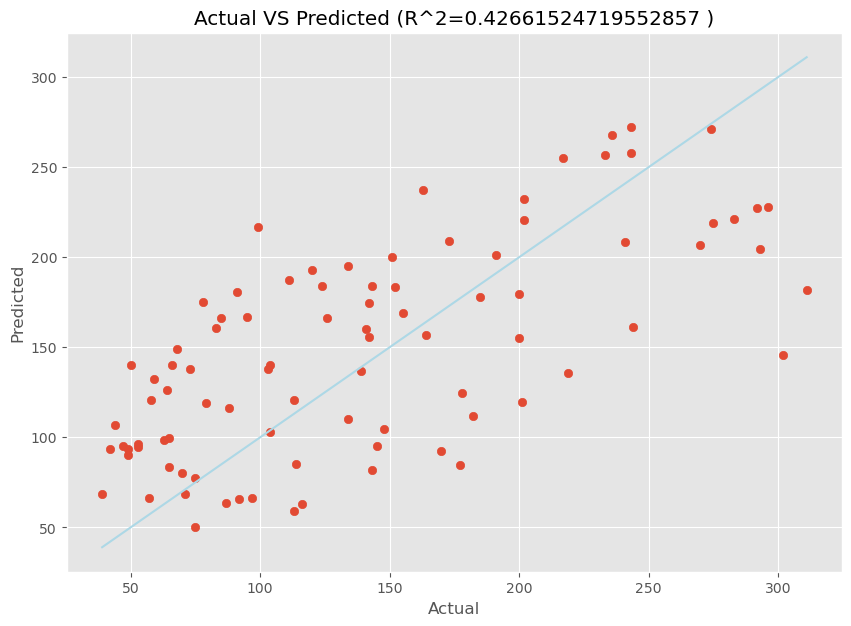

In [8]:
from azureml.core import Model
run_id = best_run.id
model_name = best_run.properties['model_name'] # AutoML default name
model = Model(ws, model_name) # Now model AutoML92197e33d0 exists in workspace

rmse, r2, mean_abs_percent_error,mae,spearman_correlation,plt, dummy = test_scoring.get_test_scoring_8(ws,target_column_name,test_ds,fitted_model,best_run,model)
print("Scoring for NEW model is: {},{},{},{}, {}".format(rmse,r2,mean_abs_percent_error,mae,spearman_correlation))

# 3) Compare models - INNER LOOP (in DEV environment)

#### NB! Here also MAIN_RUN is used, which is different from a PIPELINE_RUN where BEST_RUN is used

In [9]:
#best_run, fitted_model, experiment
promote_new_model,source_model_name,new_run_id,target_model_name, target_best_run_id,target_workspace,source_model = comparer.compare_scoring_current_vs_new_model(
    new_run_id = main_run.id, # main_run.id ....not best_run.id
    current_ws = ws,
    current_environment = esml_current_env,
    target_environment = esml_current_env,
    target_workspace = ws,
    experiment_name = controller.experiment_name)

source_best_run.properties['model_name'] is: AutoMLd1093aff80
TARGET is in the same Azure ML Studio workspace as SOURCE, comparing with latest registered model...
TIME: Model list LAMBDA FILTER, on experiment_name 11_diabetes_model_reg
TIME: FILTER ModelList:
Minutes: 4.276224029064179
target_best_run_id AutoML_d1093aff-84fe-45d8-939f-effe3092dd4c
New trained model & cached RUN, has TASK_TYPE: regression and Best_Run_id: AutoML_d1093aff-84fe-45d8-939f-effe3092dd4c_0
Target model & RUN, in Azure ML Studio workspace to compare with, has TASK_TYPE: regression and Best_Run_id:AutoML_d1093aff-84fe-45d8-939f-effe3092dd4c_0 

Q: Do we have SCORING DRIFT / CONCEPT DRIFT? - Is a model trained on NEW data better? = the one in production degraded?

New trained model: model id AutoMLd1093aff80:3
INFO: Using ESML TEST_SET SCORING, since tagged on MODEL - using this to compare SCORING
RMSE (normalized_root_mean_squared_error): 56.501912
MAPE (Mean average Percentage Error): 0.339886
MAE (normalized_

# 4) Promote model, if better - INNER LOOP (in DEV environment)

In [14]:
source_model.tags

{'run_id': 'AutoML_d1093aff-84fe-45d8-939f-effe3092dd4c',
 'model_name': None,
 'trained_in_environment': 'dev',
 'trained_in_workspace': 'msft-weu-DEV-eap-proj02_ai-amls',
 'experiment_name': '11_diabetes_model_reg',
 'status_code': 'esml_newly_trained',
 'trained_with': 'AutoMLRun',
 'test_set_RMSE': '56.501912',
 'test_set_R2': '0.426615',
 'test_set_MAPE': '0.339886',
 'test_set_Spearman_Correlation': '0.649199',
 'esml_time_updated': '09/07/2022, 02:03:21'}

In [15]:
promote_new_model = True # Force promote, for DEMO purposes
if(promote_new_model):
    model_registered_in_target = controller.register_model(source_ws=ws, target_env=esml_current_env, source_model=source_model, run=main_run,esml_status=IESMLController.esml_status_promoted) 
    print("Promoted model! in environment {}".format(esml_current_env))

Connecting to env: dev
- ws name: msft-weu-DEV-eap-proj02_ai-amls
- self._secret_name_tenant: kv-msft-weu-dev-cmnai-tenant
- self._secret_name_project_sp_id: kv-secret-esml-project002-sp-id
- self._secret_name_project_sp_secret: kv-secret-esml-project002-sp-secret
Connecting to env: dev
- ws name: msft-weu-DEV-eap-proj02_ai-amls
- self._secret_name_tenant: kv-msft-weu-dev-cmnai-tenant
- self._secret_name_project_sp_id: kv-secret-esml-project002-sp-id
- self._secret_name_project_sp_secret: kv-secret-esml-project002-sp-secret
Could not get model_name from run.properties
'model_name'
registering model with name: AutoMLd1093aff80, from run.
model_name at emote_run.register_model:  AutoMLd1093aff80
model.version 5
Model name AutoMLd1093aff80 is registered.
Promoted model! in environment dev


# 3) DEPLOY ONLINE - FROM TEST in DEV - ESML `Deploy model ONLINE` in `2 lines of code` (AKS) 
- Deploy "offline" MODEL from old `run` in environment To →  `DEV`, `TEST` or `PROD` environment
- ESML saves `API_key in Azure keyvault automatically`
- ESML auto-config solves 4 common 'errors/things': `correct compute name` and `valid replicas, valid agents, valid auto scaling`
    - Tip: You can adjust the number of replicas, and different CPU/memory configuration, or using a different compute target.

In [16]:
target_env = "dev"
inference_config = p.get_active_inference_config(best_run,target_env)

best_model,run_id_tag, model_name_tag = IESMLController.get_best_model_via_modeltags_only_DevTestProd(ws,controller.experiment_name)
service,api_uri, kv_aks_api_secret= p.deploy_automl_model_to_aks(best_model,inference_config,overwrite_endpoint=True) # Deploy: AKS dockerized with correct config (Dev,Test or Prod subscription & networking)

Note: OVERRIDING enterprise performance settings with project specifics. (to change, set flag in 'dev_test_prod_settings.json' -> override_enterprise_settings_with_model_specific=False)
Loading AutoML config settings from: dev
TIME: Model list LAMBDA FILTER, on experiment_name 11_diabetes_model_reg
TIME: FILTER ModelList:
Minutes: 4.878815992673238
Deploying model: AutoMLd1093aff80 with verison: 5 to environment: dev with overwrite_endpoint=True
Note: OVERRIDING enterprise performance settings with project specifics. (to change, set flag in 'dev_test_prod_settings.json' -> override_enterprise_settings_with_model_specific=False)
image_build_compute = p02-m11weu-dev
Note: OVERRIDING enterprise performance settings with project specifics. (to change, set flag in 'dev_test_prod_settings.json' -> override_enterprise_settings_with_model_specific=False)
Found existing cluster, esml-dev-prj02, using it.
Note: Autoscale_enabled=False, or since aks_dev_test=True in config, autoscaling is automat

## 3b) DEPLOY - Online scornig: Smoke testing with ESML `2 lines of code`

In [21]:
p.connect_to_lake()
X_test, y_test, tags = p.get_gold_validate_Xy(p.active_model['label'])
print(tags)
caller_id = "10965d9c-40ca-4e47-9723-5a608a32a0e4"

Using GEN2 as Datastore
Searching for setting in ESML datalake...
ESML in-folder settings override = TRUE 
 - Found settings in the ESML AutoLake  [active_in_folder.json,active_scoring_in_folder.json], to override ArgParse/GIT config with.
 - TRAIN in date:  1000/01/01
 - INFERENCE in date: 2021/06/08 and ModelVersion to score with: 1 (0=latest)
M11_GOLD_VALIDATE : (88, 11)
X_test  (88, 10)
y_test  (88,)
{}


In [22]:
df = p.call_webservice(p.ws, X_test,caller_id) 
df.head()

Note: OVERRIDING enterprise performance settings with project specifics. (to change, set flag in 'dev_test_prod_settings.json' -> override_enterprise_settings_with_model_specific=False)
Note: Fetching keys automatically via workspace keyvault.
Saving scoring to lake for project folder project002 and inference_model_version: 5 ...

Saved DATA to score successfully in LAKE, as file 'to_score_10965d9c-40ca-4e47-9723-5a608a32a0e4.parquet'
Saved SCORED data in LAKE, as file 'scored_10965d9c-40ca-4e47-9723-5a608a32a0e4.parquet'


,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,result
0,0.07,-0.04,0.04,-0.05,-0.02,-0.03,0.05,-0.04,-0.03,-0.04,120.30
1,0.02,-0.04,-0.02,0.04,-0.01,-0.00,-0.01,-0.00,0.02,0.02,144.77
2,0.05,-0.04,-0.02,0.02,0.03,-0.01,0.10,-0.04,0.02,-0.01,122.72
3,-0.09,-0.04,-0.08,-0.06,-0.06,-0.07,0.05,-0.08,-0.07,-0.02,42.95
4,0.05,0.05,0.00,0.07,-0.01,0.01,-0.05,0.03,0.01,0.04,202.64


# END